In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para cronometrar a leitura do csv e do FFT
import time

In [2]:
start_time = time.time()

# reduz o samplig frequency 'ratio' vezes, tomando apenas 1 a cada 'ratio' sinais
ratio = 50
sampling_freq=50000/ratio

# poupa apenas as linhas múltiplas de 'ratio' e lista as demais para exclusão
skip=[i for i in range(0,250000) if i%ratio] 

# lê dados no tempo
signals = pd.read_csv('../mafaulda/imbalance/35g/56.7296.csv', header=None, 
                      names=['tacometro','ax1','rad1','tg1','ax2','rad2','tg2','microfone'],
                      skiprows=skip)

# reordena colunas e nomeia o conjunto das acelerações
signals = signals[['tacometro','microfone','ax1','ax2','rad1','rad2','tg1','tg2']]
accelerations = signals.drop(['tacometro','microfone'], axis=1)

# transformada de Fourrier, converte para valores absolutos 
signals_fft = signals.apply(np.fft.rfft, axis=0, norm="ortho")
signals_fft = signals_fft.apply(np.abs)
# adiciona eixo da frequência
# OBS: a frequência de Nyquist é sampling_freq/2
signals_fft['freq_ax'] = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0])
accelerations_fft = signals_fft.drop(['tacometro', 'microfone'], axis=1)

end_time = time.time()

print("Sinal com shape {} obtido em {} segundos".format(signals.shape, end_time-start_time))
print("a frequência de aquisição foi reduzida de 50kHz para {}kHz\n".format(sampling_freq/1000))
# signals.head()

Sinal com shape (5000, 8) obtido em 0.9819567203521729 segundos
a frequência de aquisição foi reduzida de 50kHz para 1.0kHz



# Análise no tempo

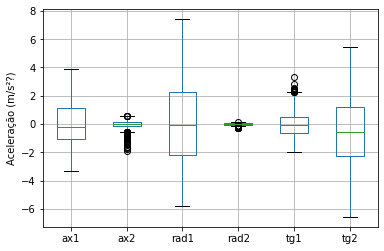

In [3]:
# checa nível dos sinais de aceleração
accelerations.boxplot()
plt.ylabel('Aceleração (m/s²?)')
plt.show()

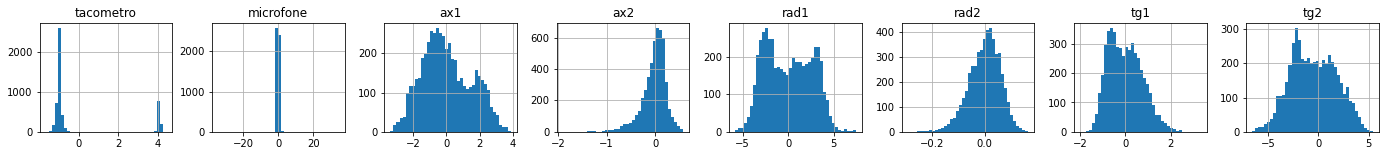

In [4]:
# exibe tabela resumo
# print(pd.DataFrame({'Médias': signals.mean(),
#                     'Medianas': signals.median(),
#                     'Intervalo máximo': signals.max()-signals.min()}), '\n')

# histograma para cada sinal
signals.hist(bins=40, figsize=(24,2), layout=(1,8))
plt.show()

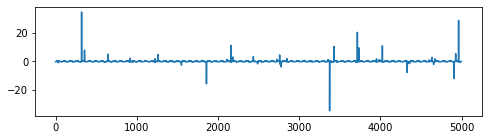

In [5]:
# detalha sinal do microfone no tempo
signals['microfone'].plot(figsize=(8,2))
plt.show()

In [6]:
# ative para 'escutar os sinais'

# from IPython.display import Audio, display
# for i, col in enumerate(signals_fft.columns.values[:-1]):
#     print('som d@ {}'.format(col))
#     display(Audio(signals[col], rate=sampling_freq))

## Dados Estatísticos
### Média, curtose e RMS

In [7]:
# Média
medias = signals.mean().to_dict()
medias = {k+'_mean': v for k,v in medias.items()}

# Curtose
curtoses = signals.kurtosis().to_dict()
curtoses = {k+'_kurt':v for k, v in curtoses.items()}

# RMS
rms = signals.pow(2).sum().pow(1/2).to_dict()
rms = {k+'_rms':v for k, v in rms.items()}

### Entropia

In [8]:
import scipy.stats as stats

# demonstração em um sinal
# # separa o sinal em faixas de 0.2 na sua unidade 
# step = 0.2
# bin_range = np.arange(-10, 10+step, step)
# out  = pd.cut(signals['ac2tg'], bins = bin_range, include_lowest=True, right=False, retbins=True)[0]

# # desta divisão, retira-se a contagem em cada uma das faixas, como em um histograma
# out.value_counts(sort=False).plot.bar()
# stats.entropy(out.value_counts())

# para todos os sinais
step = 0.2
bin_range = np.arange(-10, 10+step, step)

entropias = {}
for i, col in enumerate(signals.columns.values[:]):
    out = pd.cut(signals[col], bins = bin_range, include_lowest=True, right=False, retbins=True)[0]
    entropias[col] = stats.entropy(out.value_counts())

entropias = {k+'_entropy':v for k,v in entropias.items()}

### Combinação dos patâmetros estatísticos

In [9]:
time_statistics = entropias
time_statistics.update(medias)
time_statistics.update(curtoses)
time_statistics.update(rms)

# Análise na frequência

## Fundamental

In [10]:
# dentre os 3 maiores picos na fft do tacômetro, deve retornar o de menor frequência
# assim, evita-se o mascaramento da fundamental pelas harmonicas
fundamental_candidates = [0, 0, 0]

for i in range(3):
    index = signals_fft['tacometro'].argmax()
    fundamental_candidates[i] = signals_fft.freq_ax[index]
    for j in range(-2, 3):
        signals_fft.tacometro[index+j] = 0

fundamental = min(fundamental_candidates)
index = signals_fft.index[signals_fft['freq_ax'] == fundamental]


## Hamônicas

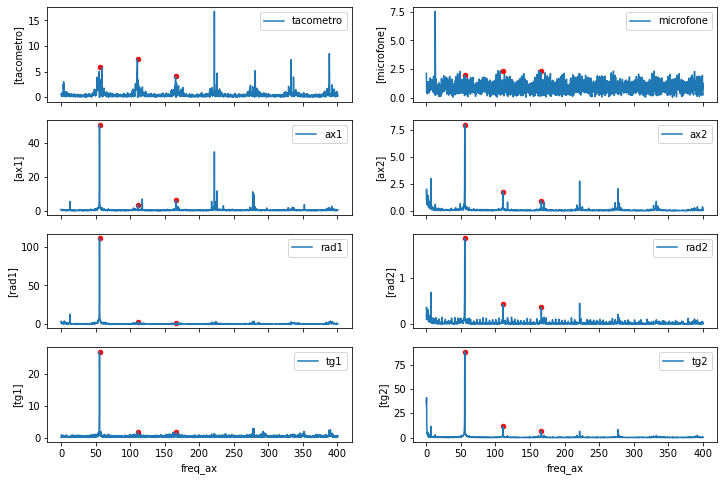

In [11]:
idx = index[0]
harmonic_values = pd.DataFrame(columns = signals_fft.columns)
harmonic_values


for i in range(1,4):
    # resgata no DataFrame os valores na harmonica i
    harmonic_values = harmonic_values.append(signals_fft.iloc[idx*i-25:idx*i+26].max(), ignore_index=True)
    harmonic_values.iloc[-1]['freq_ax'] = fundamental*i
#     harmonic_values = pd.concat([harmonic_values, signals_fft.iloc[idx*i-4:idx*i+5].max()], axis=1)


fig, axes = plt.subplots(4,2,figsize=(12, 8),sharex=True)

for i, col in enumerate(signals_fft.columns.values[:-1]):
    signals_fft[:2000].plot(x='freq_ax', y=[col], ax=axes[i//2,i%2])
    harmonic_values.plot(x='freq_ax', y=[col], ax=axes[i//2,i%2], kind='scatter', color="red")
    
plt.show()

In [12]:
# função implementada na extração de dados

def extract_n_harmonics(fft_df, fund_index, n_harmonics=3):
    #protege o DataFrame original de alterações
    fft_df = fft_df.copy()
    
    # extrai todos os valores nos primeiros n harmônicos, exceto para o tacômetro e freq_ax
    fft_df.pop('tacometro')
    fft_df.pop('freq_ax')

    harmonic_features = {}
    idx = fund_index[0]
    for i in range(n_harmonics+1):
        # resgata no DataFrame os valores na harmonica i
        if i:
            harm_values = fft_df.iloc[idx*i-10:idx*i+11].max()
        else:
            harm_values = fft_df.iloc[0]
        harm_values = harm_values.to_dict()
        
        # adiciona às features com o respectivo sulfixo do harmonico i
        harmonic_features.update({k+'_{}h'.format(i): v for k, v in harm_values.items()})

    return harmonic_features

# extract_n_harmonics(signals_fft, index, 3)

# Experimentos

## Análise das velocidades
Componentes de 'corrente contínua', de frequência igual a zero, no sinal da aceleração idicariam que o aquipamento do ensaio possui uma aceleração líquida não nula em uma dada direção. No entanto, o ensaio foi feito sobre báse estática e essa aceleração não é válida e deve ser ignorada.

O sinal de aceleração pode ser integrado para obtenção da velocidade no mesmo eixo. Esta interação, no entanto, causa maior atenuação em altas frequências e acaba exacerbando componentes de baixa frequência. Para evitar a dominação se componentes espúrios de baixa frequência, propõe-se a aplicação de um filtro passa alta no sinal de velocidade.

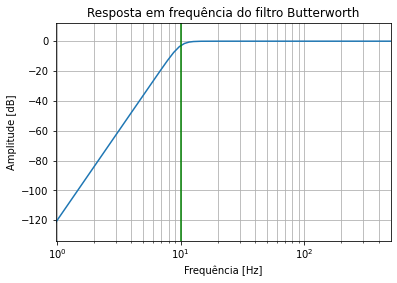

In [13]:
# ilustração do filtro passa alta
from scipy import signal

b, a = signal.butter(6, 10, 'highpass', fs=sampling_freq)
w, h = signal.freqz(b, a, fs=sampling_freq)
plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Resposta em frequência do filtro Butterworth')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(10, color='green') # cutoff frequency
plt.show()

In [14]:
# calcula velocidade pela integral (retangular) dos sinais 
# REPARE: dt = periodo de amostragem = 1/sampling_freq
velocity = accelerations.cumsum()
velocity = velocity.apply(lambda t: t/sampling_freq, axis=0)

# adequa o nome das colunas
velocity = velocity.rename(columns ={
    'ax1': 'v_ax1',
    'ax2': 'v_ax2'
    'rad1':'v_rad1',
    'rad2':'v_rad2',
    'tg1': 'v_tg1',
    'tg2': 'v_tg2',
})

# instancia o filtro passa alta
sos = signal.butter(6, 10, 'highpass', fs=sampling_freq, output='sos')

# aplica o filtro no sinal integrado                                     
filtered_velocity = pd.DataFrame(columns=velocity.columns)
for col in velocity.columns:
    filtered_velocity[col] = signal.sosfilt(sos, velocity[col])

# aplica a transformada no sinal filtrado                                     
velocity_fft = filtered_velocity.apply(np.fft.rfft, axis=0, norm="ortho")
velocity_fft = velocity_fft.apply(np.abs)
velocity_fft['freq_ax'] = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0])

SyntaxError: invalid syntax (<ipython-input-14-49df32232a93>, line 10)

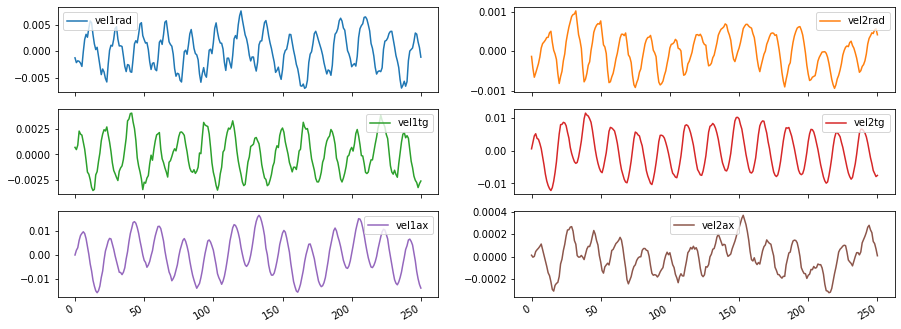

In [182]:
# velocidades no tempo 
filtered_velocity.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8))
plt.show()

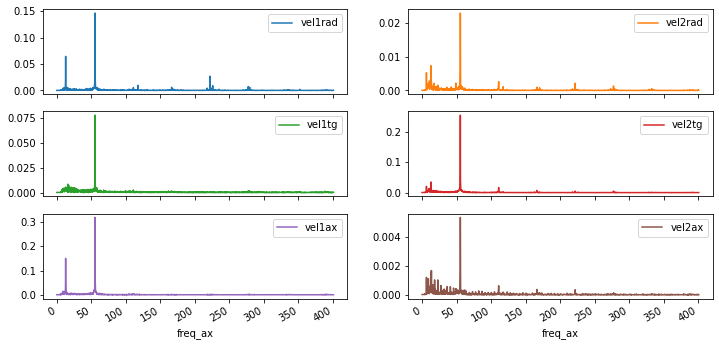

In [192]:
# velocidades na frequência
velocity_fft.loc[:2000].plot(subplots=True, x='freq_ax', layout=(4,2), figsize=(12,8))
plt.show()

     vel1rad  vel2rad  vel1tg  vel2tg  vel1ax  vel2ax
277    0.458    0.072   0.242   0.797   1.000   0.017
     ac1rad  ac2rad  ac1tg  ac2tg  ac1ax  ac2ax
277   0.458   0.072  0.242  0.796  1.000  0.017


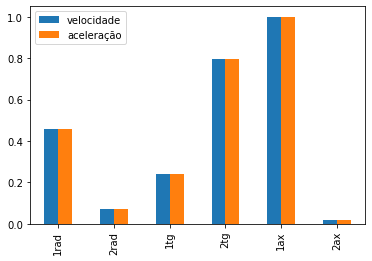

In [283]:
# faz tabulação dos valores de velocidade
vel = velocity_fft.iloc[index].drop('freq_ax', axis=1)
vel = vel/vel.max().max()
print(vel)
vel.columns = [col[3:] for col in vel.columns]
vel.rename(index={index[0]:'velocidade'}, inplace=True)

acc = accelerations_fft.iloc[index].drop('freq_ax', axis=1)
acc = acc/acc.max().max()
print(acc)
acc.columns = [col[2:] for col in acc.columns]
acc.rename(index={index[0]:'aceleração'}, inplace=True)

pd.concat([vel,acc]).T.plot(kind='bar')
plt.show()

Será comparado o valor do pico de cada sinal na frequência fundamental, para velocidade e para aceleração. Os valores foram normalizados pelo maior valor entre os eixos, para melhor visualização.

## Extração ingênua dos picos na frequência
Note que há uma série de valores elevados em torno de um mesmo pico, confundindo a análise.

**Conclusão:** não há ganho de informação quando se extrai o pico da 1a harmônica do sinal da velocidade. 

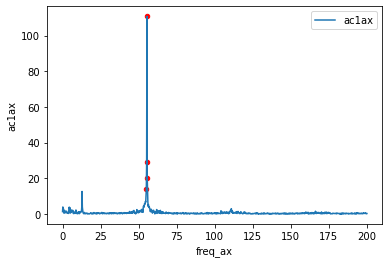

,freq_ax,ac1ax,harmonic
277,55.511,110.766,1.000
276,55.310,28.943,0.996
278,55.711,20.141,1.004
275,55.110,14.142,0.993


In [151]:
STUDY_FFT = signals_fft[['freq_ax','ac1ax']]

col_name = STUDY_FFT.columns[1]
ordered_study_fft = STUDY_FFT.sort_values(by=col_name, ascending=False) # ordenando o sinal
ordered_study_fft['n_harmonic'] = ordered_study_fft['freq_ax']/fundamental

pd.options.display.float_format = '{:,.3f}'.format


ax = signals_fft.iloc[:1000,:].plot(x='freq_ax', y=col_name)
ordered_study_fft.iloc[:4,:].plot(x='freq_ax', y=col_name, kind='scatter', color='red', ax=ax)
plt.show()

# mostra tabela
ordered_study_fft.iloc[:4,:]

## *TODO:* retirar integral em torno dos picos